In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import calendar
from sklearn.decomposition import PCA as PCA
from sklearn.linear_model import LinearRegression
from numba import jit
from HMM_Cal import execute
%matplotlib inline

In [27]:
data=pd.read_csv('/Users/liyuefan/Documents/gtja/sz50.csv',header=2,encoding='gbk')

In [28]:
data[u'日期']=pd.to_datetime(data[u'日期'])

In [29]:
data.index=[data[u'日期']]
data.drop([u'日期'],axis=1,inplace=True)

In [30]:
d=data.apply(np.log)

In [31]:
data['ma30']=pd.rolling_mean(data[u'收盘价.50'],30)
data['ma60']=pd.rolling_mean(data[u'收盘价.50'],60)
data['position']=data['ma30']-data['ma60']
data['position']=data['position'].apply(lambda x:1 if x>0 else -1)
position=data[['position']]

In [32]:
d=d.diff()

In [33]:
d=d.iloc[1:,:]

In [34]:
d=d.fillna(0)
for col in d.columns:
    d[col]=d[col].apply(lambda x: 0 if x==np.inf or x==-np.inf else x)

In [35]:
SZ50=d[[u'收盘价.50']]

In [36]:
X=d.drop([u'收盘价.50'],axis=1)

In [37]:
def pca_weight(ind_var_diff):
#     X=ind_var_diff.as_matrix()
    X=ind_var_diff
    pca=PCA(n_components=10,whiten=True)

    pca.fit(X)

    X=pca.transform(X)

    r=pd.DataFrame(pca.components_[0])
#     r['name']=map(name_kind,ind_var_diff.columns)
#     r.index=[r['name']]

#     r.drop('name',axis=1,inplace=True)
    

    ##定义一个函数用来画各个主成分的构成loading


    # plot_loading(r)

    # 计算loading
    eigenvalues=pca.explained_variance_ratio_
    sqrt_eigen=np.sqrt(pca.explained_variance_ratio_)
#     loadings=pd.DataFrame()
#     for i in range(len(sqrt_eigen)):
#         loadings['PC%s'%(i+1)]=r[i]**2
    
#     loadings['all_weights']=loadings.sum(axis=1)
    weights=r[0]
    


    weights=weights/sum(weights)
    return list(weights),eigenvalues[0]



In [38]:
d_s=min(X.index)+np.timedelta64(6,'M')
d_t=max(X.index)
total=[]
pca_all=[]
for day in pd.date_range(d_s,d_t):
    train_s=day-np.timedelta64(6,'M')
    train_t=day-np.timedelta64(1,'D')
    test_s=day
    test_t=day+np.timedelta64(3,'M')
    train=X[train_s:train_t]
    test=X[test_s:test_t]
    train=train.as_matrix()
    test=test.as_matrix()
    w,pca=pca_weight(train)
    pca_all.append([pca,day])
    if day.month in [1,4,7,10] and day.day==1:
        w.append(day)
        total.append(w)  
    else:
        w=[np.nan for x in np.arange(X.shape[1])]
        w.append(day)
#             pca_all.append([np.nan,day])
        total.append(w)
col_list=list(X.columns)
col_list.append('update_date')
all_w=pd.DataFrame(total,columns=col_list)
all_w['update_date']=pd.to_datetime(all_w['update_date'])
all_w=all_w.fillna(method='ffill')
all_w=all_w.dropna(axis=0)
pca_all=pd.DataFrame(pca_all,columns=['dir_strength','update_date'])
pca_all['update_date']=pd.to_datetime(pca_all['update_date'])
pca_all['update_date']=pca_all['update_date'].apply(lambda x: x.date())
pca_all.index=[pca_all['update_date']]
pca_all.drop(['update_date'],axis=1,inplace=True)


In [39]:
all_w['update_date']=all_w['update_date'].apply(lambda x:x.date())

In [40]:
all_w.index=[all_w['update_date']]
all_w.drop('update_date',axis=1,inplace=True)

In [41]:
return_mat=X
return_mat['temp']=1
all_w=pd.concat([all_w,return_mat[['temp']]],axis=1,join='inner')
all_w.drop('temp',axis=1,inplace=True)
return_mat.drop('temp',axis=1,inplace=True)

In [42]:
np.min(list(all_w.index))

datetime.date(2006, 7, 3)

In [43]:
return_mat=X[pd.to_datetime(np.min(list(all_w.index))):pd.to_datetime(np.max(list(all_w.index)))]

In [44]:
all_w_mat=all_w.as_matrix()
return_mat_mat=return_mat.as_matrix()
cal_mat=np.dot(return_mat_mat,all_w_mat.T)
return_series=cal_mat.diagonal()

f=pd.DataFrame()
f['update_date']=all_w.index
f['beta_return']=return_series
f.index=[f['update_date']]
f=pd.concat([f,pca_all[['dir_strength']]],axis=1,join='inner')
f['dir_strength']=f['dir_strength'].fillna(method='ffill')
f['dir_strength_threshold']=f['dir_strength'].rolling(60).quantile(0.25)
dir_strength_threshold=[np.nan]
dir_strength_threshold.extend(f['dir_strength_threshold'][:-1])
f['dir_strength_threshold']=dir_strength_threshold
f['dir_strength']=f['dir_strength']-f['dir_strength_threshold']
f['dir_strength']=f['dir_strength'].apply(lambda x: 1 if x>0 else 0)
f.drop('update_date',axis=1,inplace=True)
f=pd.concat([f,SZ50],axis=1,join='inner')
f['diff_return']=f[u'收盘价.50']-f['beta_return']

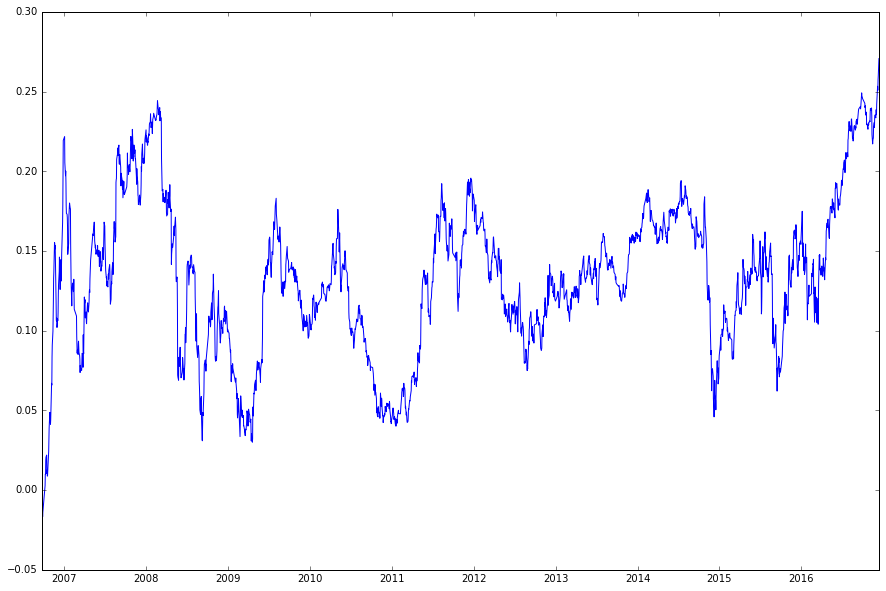

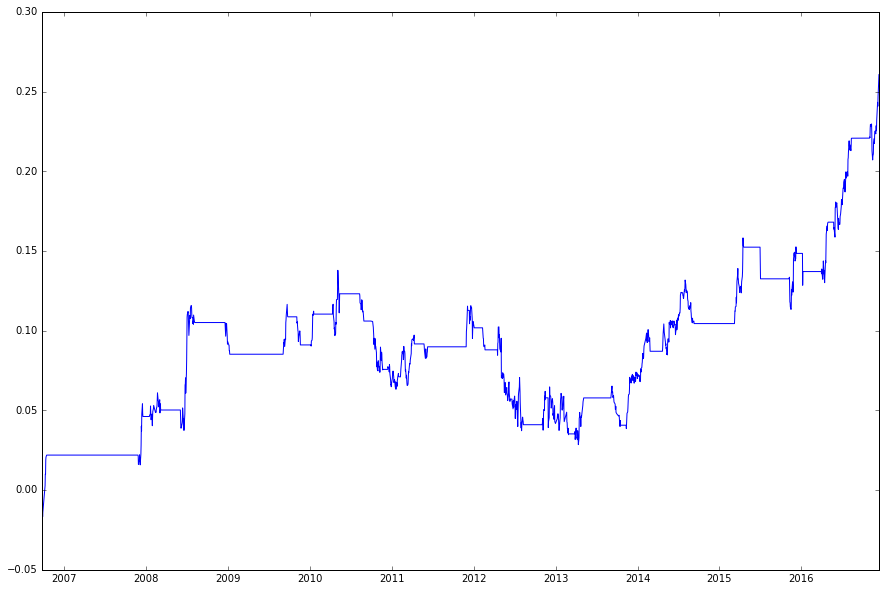

In [45]:
f=pd.concat([f,position],axis=1,join='inner')
f=f.dropna(axis=0)
f['daily_return']=f['diff_return']*f['position']
f['strategy_cum_return']=f['daily_return'].cumsum()
plt.figure(figsize=(15,10))
plt.plot(f['strategy_cum_return'])

position_lag=[np.nan]
position_lag.extend(f['position'][:-1])
f['position_lag']=position_lag

f['position']=f['position']-f['position_lag']
f['position']=f['position'].fillna(2.)
f['position']=f['position']/2
# f['position']=f['position']*f['dir_strength']
f['position']=f['position'].apply(lambda x:np.nan if x==0 else x)

f['trade_num']=f['position'].apply(abs)
f['trade_num']=f['trade_num'].fillna(0)
f['trade_num']=f['trade_num'].cumsum()


f_all=pd.DataFrame()
for i,j in f.groupby('trade_num'):
    j=j.sort()
    j['trade_cum_return']=j['daily_return'].cumsum()
    j['trade_cum_max']=j['trade_cum_return'].cummax()
    j['cum_threshold']=j['trade_cum_max'].apply(lambda x: 0.75*x if x>=0.02 else -0.02)
    stop=[-0.02]
    stop.extend(j['cum_threshold'][:-1])
    j['cum_threshold']=stop
    j['compare']=j['trade_cum_return']-j['cum_threshold']
    j['daily_return']=j['daily_return']+np.abs(j['compare'].apply(lambda x: x if x<0 else 0))
    j['temp']=j['compare'].apply(lambda x: 0 if x<0 else np.nan)
    j['position']=j['position'].fillna(j['temp'])
    j['position']=j['position'].fillna(method='ffill')
    j['daily_return']=np.abs(j['position'])*j['daily_return']
    j['trade_cum_return']=j['daily_return'].cumsum()
    j['trade_cum_max']=j['trade_cum_return'].cummax()
    j['trade_drawdown']=j['trade_cum_max']-j['trade_cum_return']
    f_all=f_all.append(j)
    
f_all['strategy_cum_return_stoploss']=f_all['daily_return'].cumsum()

plt.figure(figsize=(15,10))
plt.plot(f_all['strategy_cum_return_stoploss'])

In [46]:
f['cum_return']=f['diff_return'].cumsum()

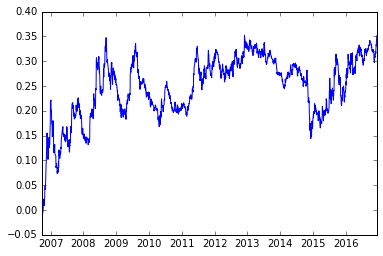

In [47]:
plt.plot(f['cum_return'])

In [48]:
cum_1=f['beta_return'].cumsum()
cum_2=f[u'收盘价.50'].cumsum()

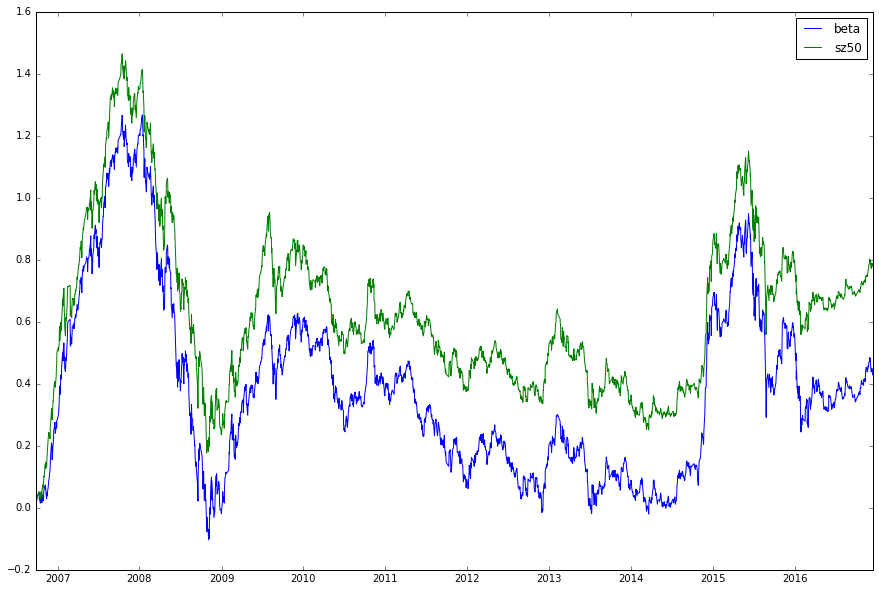

In [49]:
plt.figure(figsize=(15,10))
plt.plot(cum_1,label='beta')
plt.plot(cum_2,label='sz50')
plt.legend()